In [1]:
import cython
import numpy as np
import TidalPy
import CyRK
print('TidalPy', TidalPy.__version__)
print('CyRK', CyRK.__version__)

TidalPy 0.5.0a5.dev19
CyRK 0.8.3a0.dev0


In [2]:
%load_ext cython

## Radial Solver Function


In [3]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False


cdef void add_(double a, double b):
    
    cdef double c
    c = a + b

cdef void mult_(double a, double b):
    
    cdef double c
    c = a * b

def wrap_add():
    add_(10., -32.)

def wrap_mult():
    mult_(10., -32.)

Content of stdout:
_cython_magic_4d291345160e5caca2a8f2eb21cdc8e1b4bec34d.cpp
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_4d291345160e5caca2a8f2eb21cdc8e1b4bec34d.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_4d291345160e5caca2a8f2eb21cdc8e1b4bec34d.cp311-win_amd64.exp
Generating code
Finished generating code

In [20]:
%%cython --annotate --force
# distutils: language = c++
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False

from scipy.constants import G as G_
from libc.math cimport pi, sqrt, NAN, fmax

cdef double G = G_

from libcpp cimport bool as bool_cpp_t

ctypedef fused double_numeric:
    double
    double complex

from cpython.mem cimport PyMem_Malloc, PyMem_Realloc, PyMem_Free

import numpy as np
cimport numpy as np

from TidalPy.radial_solver.nondimensional import re_dimensionalize_radial_func
from TidalPy.radial_solver.numerical.collapse import collapse_solutions
from TidalPy.radial_solver.numerical.initial import find_initial_guess
from TidalPy.radial_solver.numerical.interfaces import find_interface_func

# Import cythonized functions
from TidalPy.radial_solver.numerical.interfaces.interfaces_x cimport find_solution_num
from TidalPy.radial_solver.numerical.derivatives.ode_base_x cimport RadialSolverBase
from TidalPy.radial_solver.numerical.derivatives.odes_x cimport build_solver



from scipy.linalg.cython_lapack cimport zgesv



cdef void non_dimensionalize_physicals_x(
        Py_ssize_t num_radius,
        double frequency,
        double mean_radius,
        double bulk_density,
        double* radius_array_ptr,
        double* density_array_ptr,
        double* gravity_array_ptr,
        double* bulk_array_ptr,
        double_numeric* shear_array_ptr,
        double* frequency_to_use,
        double* G_to_use
        ):

    # Setup loop variables
    cdef Py_ssize_t i

    # Setup conversions
    cdef double second2_conversion, second_conversion, length_conversion
    cdef double density_conversion, mass_conversion, pascal_conversion
    second2_conversion = 1. / (pi * G * bulk_density)
    second_conversion  = sqrt(second2_conversion)
    length_conversion  = mean_radius
    density_conversion = bulk_density
    mass_conversion    = bulk_density * mean_radius**3
    pascal_conversion  = mass_conversion / (length_conversion * second2_conversion)

    # Convert array pointers
    for i in range(num_radius):
        radius_array_ptr[i]    /= length_conversion
        density_array_ptr[i]   /= density_conversion
        gravity_array_ptr[i]   /= (length_conversion / second2_conversion)
        bulk_array_ptr[i]      /= pascal_conversion
        shear_array_ptr[i]     /= pascal_conversion

    # Convert non-array pointers
    G_to_use[0]         = G / (length_conversion**3 / (mass_conversion * second2_conversion))
    frequency_to_use[0] = frequency / (1. / second_conversion)





    
    
    
    
    
    

cdef Py_ssize_t MAX_NUM_SOLS    = 3
cdef Py_ssize_t MAX_NUM_YS      = 6
cdef Py_ssize_t MAX_NUM_YS_REAL = 2 * MAX_NUM_YS



def radial_solver_x(
        double[:] radius_array,
        double[:] density_array,
        double[:] gravity_array,
        double[:] bulk_modulus_array,
        double complex[:] complex_shear_modulus_array,
        double frequency,
        double planet_bulk_density,
        tuple is_solid_by_layer,
        tuple is_static_by_layer,
        tuple is_incompressible_by_layer,
        tuple upper_radius_by_layer,
        unsigned int degree_l = 2,
        double complex[:] surface_boundary_conditions = None,
        bool_cpp_t solve_load_numbers = False,
        bool_cpp_t use_kamata = False,
        int integration_method = 1,
        double integration_rtol = 1.0e-4,
        double integration_atol = 1.0e-12,
        bool_cpp_t scale_rtols_by_layer_type = True,
        Py_ssize_t max_num_steps = 500_000,
        Py_ssize_t expected_size = 250,
        double max_step = 0,
        bool_cpp_t limit_solution_to_radius = True,
        bool_cpp_t verbose = False,
        bool_cpp_t nondimensionalize = True,
        ):
    # General indexing
    cdef Py_ssize_t i, j, k

    # Layer | Solution | y indexing
    cdef Py_ssize_t layer_i, solution_i, y_i, slice_i

    # Pull out key information
    cdef double radius_planet
    cdef Py_ssize_t num_layers, num_interfaces, total_slices

    total_slices   = len(radius_array)
    radius_planet  = radius_array[total_slices - 1]
    num_layers     = len(is_solid_by_layer)
    num_interfaces = num_layers - 1

    # Ensure there are enough slices for radial interpolations.
    if total_slices <= (3 * num_layers):
        raise AttributeError('Radial solver requires at least 3 radial slices per layer (ideally >= 10 per).')

    # Ensure there is at least one layer.
    if num_layers <= 0:
        raise AttributeError('Radial solver requires at least one layer.')

    # Build main input pointers
    cdef double* radius_array_ptr = <double *> PyMem_Malloc(total_slices * sizeof(double))
    if not radius_array_ptr:
        raise MemoryError()

    cdef double* density_array_ptr = <double *> PyMem_Malloc(total_slices * sizeof(double))
    if not density_array_ptr:
        raise MemoryError()

    cdef double* gravity_array_ptr = <double *> PyMem_Malloc(total_slices * sizeof(double))
    if not gravity_array_ptr:
        raise MemoryError()

    cdef double* bulk_array_ptr = <double *> PyMem_Malloc(total_slices * sizeof(double))
    if not bulk_array_ptr:
        raise MemoryError()

    cdef double complex* cmplx_shear_array_ptr = <double complex *> PyMem_Malloc(total_slices * sizeof(double complex))
    if not cmplx_shear_array_ptr:
        raise MemoryError()

    # Populate the arrays (making a copy of values)
    for slice_i in range(total_slices):
        radius_array_ptr[slice_i]      = radius_array[slice_i]
        density_array_ptr[slice_i]     = density_array[slice_i]
        gravity_array_ptr[slice_i]     = gravity_array[slice_i]
        bulk_array_ptr[slice_i]        = bulk_modulus_array[slice_i]
        cmplx_shear_array_ptr[slice_i] = complex_shear_modulus_array[slice_i]

    # Non-dimensionalize inputs
    cdef double G_to_use, frequency_to_use
    if nondimensionalize:
        non_dimensionalize_physicals_x(
            total_slices,
            frequency,
            radius_planet,
            planet_bulk_density,
            radius_array_ptr,
            density_array_ptr,
            gravity_array_ptr,
            bulk_array_ptr,
            cmplx_shear_array_ptr,
            &frequency_to_use,
            &G_to_use
            )
    else:
        # Leave inputs alone.
        G_to_use         = G
        frequency_to_use = frequency

    cdef double surface_gravity
    surface_gravity = gravity_array_ptr[total_slices - 1]

    # Find boundary condition at the top of the planet -- this is dependent on the forcing type.
    #     Tides (default here) follow the (y2, y4, y6) = (0, 0, (2l+1)/R) rule
    cdef double complex[3] boundary_conditions
    cdef double complex* bc_pointer = &boundary_conditions[0]

    if surface_boundary_conditions is None:
        # Assume tides
        for i in range(3):
            if i == 2:
                if nondimensionalize:
                    bc_pointer[i] = (2. * degree_l + 1.) / 1.
                else:
                    bc_pointer[i] = (2. * degree_l + 1.) / radius_planet
            else:
                bc_pointer[i] = 0.
    else:
        # Use user input
        if len(surface_boundary_conditions) != 3:
            raise AttributeError('Unexpected number of user-provided surface boundary conditions.')
        for i in range(3):
            bc_pointer[i] = surface_boundary_conditions[i]

    # Integration information
    # Max step size
    cdef double max_step_touse
    cdef bool_cpp_t max_step_from_arrays
    max_step_from_arrays = False
    if max_step == 0:
        # If max_step is zero use the array information to determine max_step_size
        max_step_from_arrays = True
    else:
        # Otherwise use user input.
        max_step_touse = max_step

    # Setup tolerance arrays
    # For simplicity just make these all as large as the maximum number of ys.
    cdef double* rtols_by_layer_ptr = <double *> PyMem_Malloc(num_layers * MAX_NUM_YS_REAL * sizeof(double))
    if not rtols_by_layer_ptr:
        raise MemoryError()

    cdef double* atols_by_layer_ptr = <double *> PyMem_Malloc(num_layers * MAX_NUM_YS_REAL * sizeof(double))
    if not atols_by_layer_ptr:
        raise MemoryError()

    # Find number of solutions per layer
    cdef Py_ssize_t* num_solutions_by_layer_ptr = <Py_ssize_t *> PyMem_Malloc(num_layers * sizeof(Py_ssize_t))
    if not num_solutions_by_layer_ptr:
        raise MemoryError()

    cdef Py_ssize_t* start_index_by_layer_ptr = <Py_ssize_t *> PyMem_Malloc(num_layers * sizeof(Py_ssize_t))
    if not start_index_by_layer_ptr:
        raise MemoryError()

    cdef Py_ssize_t* num_slices_by_layer_ptr = <Py_ssize_t *> PyMem_Malloc(num_layers * sizeof(Py_ssize_t))
    if not num_slices_by_layer_ptr:
        raise MemoryError()

    cdef bool_cpp_t layer_is_solid, layer_is_static, layer_is_incomp
    cdef bool_cpp_t layer_below_is_solid, layer_below_is_static, layer_below_is_incomp
    cdef double layer_upper_radius, radius_check
    cdef double layer_rtol_real, layer_rtol_imag, layer_atol_real, layer_atol_imag
    cdef Py_ssize_t layer_slices, num_sols, num_ys
    cdef int num_sols_int

    for layer_i in range(num_layers):
        # Pull out information on this layer
        layer_is_solid     = is_solid_by_layer[layer_i]
        layer_is_static    = is_static_by_layer[layer_i]
        layer_is_incomp    = is_incompressible_by_layer[layer_i]
        layer_upper_radius = upper_radius_by_layer[layer_i]

        # Find number of solutions based on this layer's assumptions
        num_sols = <Py_ssize_t>find_solution_num(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp
            )
        num_ys = 2 * num_sols
        num_solutions_by_layer_ptr[layer_i] = num_sols

        # Scale rtols by layer type
        for y_i in range(num_ys):
            # Default is that each layer's rtol and atol equal user input.
            layer_rtol_real = integration_rtol
            layer_rtol_imag = integration_rtol
            layer_atol_real = integration_atol
            layer_atol_imag = integration_atol

            if scale_rtols_by_layer_type:
                # Certain layer assumptions can affect solution stability so use additional scales on the relevant rtols
                # TODO test that these scales are the best.
                if layer_is_solid:
                    # Scale y2 and y3 by 0.1
                    if (y_i == 1) or (y_i == 2):
                        # Scale both the real and imaginary portions by the same amount.
                        layer_rtol_real *= 0.1
                        layer_rtol_imag *= 0.1
                else:
                    if not layer_is_static:
                        # Scale dynamic liquid layer's y2 by additional 0.01.
                        if (y_i == 1):
                            # Scale both the real and imaginary portions by the same amount.
                            layer_rtol_real *= 0.01
                            layer_rtol_imag *= 0.01
            # Populate rtol and atol pointers.
            rtols_by_layer_ptr[layer_i * MAX_NUM_YS_REAL + (2 * y_i)]     = layer_rtol_real
            rtols_by_layer_ptr[layer_i * MAX_NUM_YS_REAL + (2 * y_i + 1)] = layer_rtol_imag
            atols_by_layer_ptr[layer_i * MAX_NUM_YS_REAL + (2 * y_i)]     = layer_atol_real
            atols_by_layer_ptr[layer_i * MAX_NUM_YS_REAL + (2 * y_i + 1)] = layer_atol_imag

        # Determine how many slices are in this layer
        if layer_i == 0:
            # First layer starts at 0.
            start_index_by_layer_ptr[0] = 0
        else:
            # Not first layer. Starting point is based on number of slices in previous layer.
            start_index_by_layer_ptr[layer_i] = (start_index_by_layer_ptr[layer_i - 1] +
                                                 num_slices_by_layer_ptr[layer_i - 1])

        layer_slices = 0
        for slice_i in range(start_index_by_layer_ptr[layer_i], total_slices):
            radius_check = radius_array[slice_i]
            if radius_check > layer_upper_radius:
                # We have passed this layer.
                break
            layer_slices += 1
        if layer_slices <= 3:
            raise ValueError('At least three layer slices per layer are required\n\tTry using more slices in the'
                             'input arrays.')
        num_slices_by_layer_ptr[layer_i] = layer_slices

    # We have all the size information needed to build storage pointers
    # Main storage pointer is setup like [layer_i][solution_i][y_i + r_i]
    cdef double complex*** main_storage = <double complex ***> PyMem_Malloc(num_layers * sizeof(double complex**))
    if not main_storage:
        raise MemoryError()

    cdef double complex**** upper_y_solutions = <double complex ****> PyMem_Malloc(num_layers * sizeof(double complex***))
    if not upper_y_solutions:
        raise MemoryError()

    cdef double complex** storage_by_solution
    cdef double complex*** storage_by_solution_only_top
    cdef double complex* storage_by_y
    cdef double complex** storage_by_y_only_top_ptr

    for layer_i in range(num_layers):
        num_sols     = num_solutions_by_layer_ptr[layer_i]
        layer_slices = num_slices_by_layer_ptr[layer_i]
        # Number of ys = 2x num sols
        num_ys = 2 * num_sols

        storage_by_solution = <double complex**> PyMem_Malloc(num_sols * sizeof(double complex*))
        if not storage_by_solution:
            raise MemoryError()

        storage_by_solution_only_top = <double complex***> PyMem_Malloc(num_sols * sizeof(double complex**))
        if not storage_by_solution_only_top:
            raise MemoryError()

        for solution_i in range(num_sols):
            storage_by_y = <double complex*> PyMem_Malloc(layer_slices * num_ys * sizeof(double complex))
            if not storage_by_y:
                raise MemoryError()

            storage_by_y_only_top_ptr = <double complex**> PyMem_Malloc(num_ys * sizeof(double complex*))
            if not storage_by_y_only_top_ptr:
                raise MemoryError()

            storage_by_solution[solution_i]          = storage_by_y
            storage_by_solution_only_top[solution_i] = storage_by_y_only_top_ptr
        main_storage[layer_i]      = storage_by_solution
        upper_y_solutions[layer_i] = storage_by_solution_only_top

    # Storage for solutions at the top of a layer.
    cdef double complex[:, ::1] last_layer_top_solutions_view

    # Interface information
    cdef object interface_func
    cdef tuple interface_inputs

    # Layer specific pointers; set the size based on the layer with the most slices.
    cdef double* layer_radius_ptr
    cdef double* layer_density_ptr
    cdef double* layer_gravity_ptr
    cdef double* layer_bulk_mod_ptr
    cdef double complex* layer_shear_mod_ptr
    cdef double* layer_rtols_ptr
    cdef double* layer_atols_ptr

    # Properties at top and bottom of layer
    cdef double radius_lower, radius_upper
    cdef double density_lower, density_upper
    cdef double gravity_lower, gravity_upper
    cdef double bulk_lower
    cdef double complex shear_lower
    cdef tuple radial_span

    # Properties at interfaces between layers
    cdef double static_liquid_density
    cdef double interface_gravity
    cdef double last_layer_upper_gravity, last_layer_upper_density

    # Starting solutions (initial conditions / lower boundary conditions)
    cdef double complex[:, ::1] initial_solutions_view
    cdef double[:, ::1] initial_solutions_real_view

    # Intermediate values
    cdef double complex dcomplex_tmp

    # Solver class
    cdef RadialSolverBase solver

    # Feedback
    cdef str feedback_str
    cdef bool_cpp_t error
    feedback_str = 'Starting integration'
    if verbose:
        print(feedback_str)
    error = False

    cdef Py_ssize_t start_index
    for layer_i in range(num_layers):
        # Get layer's index information
        start_index  = start_index_by_layer_ptr[layer_i]
        layer_slices = num_slices_by_layer_ptr[layer_i]

        # Get solution and y information
        num_sols = num_solutions_by_layer_ptr[layer_i]
        num_ys   = 2 * num_sols

        # Setup pointer array slices starting at this layer's beginning
        layer_radius_ptr    = &radius_array_ptr[start_index]
        layer_density_ptr   = &density_array_ptr[start_index]
        layer_gravity_ptr   = &gravity_array_ptr[start_index]
        layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
        layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

        # Setup other pointers
        layer_rtols_ptr = &rtols_by_layer_ptr[layer_i * MAX_NUM_YS_REAL]
        layer_atols_ptr = &atols_by_layer_ptr[layer_i * MAX_NUM_YS_REAL]

        # Get physical parameters at the top and bottom of the layer
        radius_lower  = layer_radius_ptr[0]
        density_lower = layer_density_ptr[0]
        gravity_lower = layer_gravity_ptr[0]
        bulk_lower    = layer_bulk_mod_ptr[0]
        shear_lower   = layer_shear_mod_ptr[0]
        radius_upper  = layer_radius_ptr[layer_slices - 1]
        density_upper = layer_density_ptr[layer_slices - 1]
        gravity_upper = layer_gravity_ptr[layer_slices - 1]

        # Determine max step size (if not provided by user)
        if max_step_from_arrays:
            # Maximum step size during integration can not exceed the average radial slice size.
            max_step_touse = (radius_upper - radius_lower) / <double>layer_slices

        # Get assumptions for layer
        layer_is_solid  = is_solid_by_layer[layer_i]
        layer_is_static = is_static_by_layer[layer_i]
        layer_is_incomp = is_incompressible_by_layer[layer_i]

        # Find initial conditions for each solution at the base of this layer.
        radial_span = (radius_lower, radius_upper)
        if layer_i == 0:
            # Use initial condition function
            initial_solutions_view = find_initial_guess(
                layer_is_solid,
                layer_is_static,
                layer_is_incomp,
                use_kamata,
                radius_lower,
                shear_lower,
                bulk_lower,
                density_lower,
                frequency_to_use,
                order_l=degree_l,
                G_to_use=G_to_use
                )
        else:
            layer_below_is_solid  = is_solid_by_layer[layer_i - 1]
            layer_below_is_static = is_static_by_layer[layer_i - 1]
            layer_below_is_incomp = is_incompressible_by_layer[layer_i - 1]

            # Find gravity at the base interface using bottom of this layer and top of previous.
            interface_gravity = 0.5 * (gravity_lower + last_layer_upper_gravity)

            # Find the density needed for some initial conditions.
            if layer_is_solid and layer_below_is_solid:
                # Both layers are solid. A liquid interface density is not needed.
                static_liquid_density = NAN
            elif not layer_is_solid and layer_below_is_solid:
                # Layer below is solid, this layer is liquid. Use its density.
                static_liquid_density = density_lower
            elif layer_is_solid and not layer_below_is_solid:
                # Layer below is liquid, this layer is solid. Use layer below's density.
                static_liquid_density = last_layer_upper_density
            else:
                # Both layers are liquid. Choose the layer's density which is static.
                if layer_is_static and layer_below_is_static:
                    # Both layers are static.
                    # TODO: Not sure what to do here so just use this layer's density.
                    static_liquid_density = density_lower
                elif layer_is_static and not layer_below_is_static:
                    # This layer is static, one below is not. Use this layer's density
                    static_liquid_density = density_lower
                elif not layer_is_static and layer_below_is_static:
                    # This layer is dynamic, layer below is static. Use layer below's density
                    static_liquid_density = last_layer_upper_density
                else:
                    # Both layers are dynamic. Static liquid density is not needed.
                    static_liquid_density = NAN

            # Use results at the top of the layer below and a interface function
            interface_func, interface_inputs = find_interface_func(
                layer_below_is_solid,
                layer_below_is_static,
                layer_is_solid,
                layer_is_static,
                static_liquid_density,
                interface_gravity,
                G_to_use=G_to_use
                )

            # Run interface function
            initial_solutions_view = interface_func(
                last_layer_top_solutions_view
                *interface_inputs
                )

        # Change initial conditions into 2x real values instead of complex for integration
        # TODO: change to pointers
        initial_solutions_real_arr  = np.empty((num_sols, num_ys * 2), dtype=np.float64, order='C')
        initial_solutions_real_view = initial_solutions_real_arr
        for solution_i in range(num_sols):
            for y_i in range(num_ys):
                initial_solutions_real_view[solution_i, (2 * y_i)]     = initial_solutions_view[solution_i, y_i].real
                initial_solutions_real_view[solution_i, (2 * y_i) + 1] = initial_solutions_view[solution_i, y_i].imag

        # Build solver instance
        solver = build_solver(
            layer_is_solid,
            layer_is_static,
            layer_is_incomp,
            layer_slices,
            layer_radius_ptr,
            layer_density_ptr,
            layer_gravity_ptr,
            layer_bulk_mod_ptr,
            layer_shear_mod_ptr,
            frequency_to_use,
            degree_l,
            G_to_use,
            radial_span,
            initial_solutions_real_view[0, :],
            layer_atols_ptr,
            layer_rtols_ptr,
            integration_method,
            max_step_touse,
            max_num_steps,
            expected_size,
            limit_solution_to_radius
            )

        # Get storage pointer for this layer
        storage_by_solution = main_storage[layer_i]
        storage_by_solution_only_top = upper_y_solutions[layer_i]

        # TODO: make this pointers
        last_layer_top_solutions_arr  = np.empty((num_sols, num_ys), dtype=np.complex128, order='C')
        last_layer_top_solutions_view = last_layer_top_solutions_arr

        # Solve for each solution
        for solution_i in range(num_sols):

            if solution_i > 0:
                # Reset solver with new initial condition (this is already done for j==0)
                solver.change_y0(initial_solutions_real_view[solution_i, :], auto_reset_state=False)

            # Integrate!
            solver._solve(reset=True)

            # Check for problems
            if not solver.success:
                # Problem with integration.
                feedback_str = f'Integration problem at layer {layer_i}; solution {solution_i}:\n\t{solver.message}'
                if verbose:
                    print(feedback_str)
                error = True
                break

            # If no problems, store results.
            # Need to make a copy because the solver pointers will be reallocated during the next solution.
            # Get storage pointer for this solution
            storage_by_y              = storage_by_solution[solution_i]
            storage_by_y_only_top_ptr = storage_by_solution_only_top[solution_i]
            for slice_i in range(layer_slices):
                for y_i in range(num_ys):

                    # Convert 2x real ys to 1x complex ys
                    dcomplex_tmp = (solver.solution_y_ptr[slice_i * num_ys + (2 * y_i)] +
                                    1.0j * solver.solution_y_ptr[slice_i * num_ys + (2 * y_i) + 1])
                    storage_by_y[slice_i * num_ys + y_i] = dcomplex_tmp

                    # Store top most result for initial condition for the next layer
                    if slice_i == (layer_slices - 1):
                        last_layer_top_solutions_view[solution_i, y_i] = dcomplex_tmp

                        # Tell top storage to point to the top-most value in the main storage arrays.
                        storage_by_y_only_top_ptr[y_i] = &storage_by_y[slice_i * num_ys + y_i]

        if error:
            # Error was encountered during integration
            break

        # Prepare for next layer
        last_layer_upper_gravity = gravity_upper
        last_layer_upper_density = density_upper

    # Build final output np.ndarray.
    cdef np.ndarray[np.complex128_t, ndim=2] full_solution_arr
    cdef double complex[:, ::1] full_solution_view

    # No matter the results of the integration, we know the shape and size of the final solution.
    # The number of rows will depend on if the user wants to simultaneously calculate loading Love numbers.
    cdef Py_ssize_t num_output_ys
    if solve_load_numbers:
        num_output_ys = 12
        # TODO
        raise NotImplementedError()
    else:
        num_output_ys = 6
    full_solution_arr = np.empty((num_output_ys, total_slices), dtype=np.complex128, order='C')
    full_solution_view = full_solution_arr

    # Declare surface solution matrix
    cdef np.ndarray[np.complex128_t, ndim=2] surface_solution_matrix_arr
    cdef double complex[:, ::1] surface_solution_matrix_view

    # During collapse, variables for the layer above the target one are used. Declare these and preset them.
    cdef Py_ssize_t layer_above_num_sols = 0
    cdef double layer_above_lower_gravity = 0.
    cdef double layer_above_lower_density = 0.
    cdef double liquid_density_at_interface = 0.
    cdef bool_cpp_t layer_above_is_solid = False
    cdef bool_cpp_t layer_above_is_static = False
    cdef bool_cpp_t layer_above_is_incomp = False

    # The constant vectors are the same size as the number of solutions in the layer. But since the largest they can
    #  ever be is 3, it is more efficient to just preallocate them on the stack rather than dynamically allocate them
    #  on the heap.
    cdef double complex[3] constant_vector
    cdef double complex* constant_vector_ptr = &constant_vector[0]
    cdef double complex[3] layer_above_constant_vector
    cdef double complex* layer_above_constant_vector_ptr = &layer_above_constant_vector[0]

    # Preset constant vector to zero.
    constant_vector_ptr[0] = 0. + 0.j
    constant_vector_ptr[1] = 0. + 0.j
    constant_vector_ptr[2] = 0. + 0.j

    # Allocate surface matrices. We only need one of these (which one depends on the upper-most layer type).
    # But, since there are only 3 and all of them are small, we will just allocate all of them separately on the stack.
    cdef double complex[3][3] surface_matrix_solid
    cdef double complex[2][2] surface_matrix_liquid_dynamic
    cdef double complex[1][1] surface_matrix_liquid_static
    cdef double complex* surface_matrix_ptr

    # OPT: Could reuse some of these variables so there are not so many being allocated for this function.
    cdef double complex y4_frac_1, y4_frac_2
    cdef double complex gamma_1, gamma_2
    cdef double complex lower_s1y1, lower_s1y2, lower_s1y5, lower_s1y6
    cdef double complex lower_s2y1, lower_s2y2, lower_s2y5, lower_s2y6
    cdef double complex lambda_1, lambda_2

    # Variables used to solve the linear equation at the planet's surface.
    # These are passed to the LAPACK solver.
    # Info = flag set by the solver. Set equal to -999. This will indicate that the solver has not been called yet.
    cdef int lapack_info = -999
    # NRHS = number of solutions that will be solved at the same time. Only one will be solved per radial_solver call.
    cdef int lapack_nrhs = 1
    # IPIV = Integer pivot array that is an additional output provided by ZGESV. It is not used but must be provided.
    #  It must be at least as large as the largest dimension of the input matrix, for this work that is 3.
    cdef int[10] lapack_ipiv
    cdef int* lapack_ipiv_ptr
    lapack_ipiv_ptr = &lapack_ipiv[0]

    # Shifted or reversed indices used during collapse.
    cdef Py_ssize_t slice_i_shifted, layer_i_reversed

    if error:
        feedback_str = 'Integration failed.'
        if verbose:
            print(feedback_str)
        for y_i in range(num_output_ys):
            for slice_i in range(total_slices):
                full_solution_view[y_i, slice_i] = NAN
    else:
        feedback_str = 'Integration completed for all layers. Beginning solution collapse.'
        if verbose:
            print(feedback_str)
        # Collapse the multiple solutions for each layer into one final combined solution.

        # Work from the surface to the core.
        for layer_i in range(num_layers):
            layer_i_reversed = num_layers - (layer_i + 1)

            # Pull out layer information.
            start_index  = start_index_by_layer_ptr[layer_i_reversed]
            layer_slices = num_slices_by_layer_ptr[layer_i_reversed]

            # Get solution and y information
            num_sols     = num_solutions_by_layer_ptr[layer_i_reversed]
            num_sols_int = <int>num_sols
            num_ys       = 2 * num_sols

            # Setup pointer array slices starting at this layer's beginning
            layer_radius_ptr    = &radius_array_ptr[start_index]
            layer_density_ptr   = &density_array_ptr[start_index]
            layer_gravity_ptr   = &gravity_array_ptr[start_index]
            layer_bulk_mod_ptr  = &bulk_array_ptr[start_index]
            layer_shear_mod_ptr = &cmplx_shear_array_ptr[start_index]

            # Get physical parameters at the top and bottom of the layer
            radius_lower  = layer_radius_ptr[0]
            density_lower = layer_density_ptr[0]
            gravity_lower = layer_gravity_ptr[0]
            bulk_lower    = layer_bulk_mod_ptr[0]
            shear_lower   = layer_shear_mod_ptr[0]
            radius_upper  = layer_radius_ptr[layer_slices - 1]
            density_upper = layer_density_ptr[layer_slices - 1]
            gravity_upper = layer_gravity_ptr[layer_slices - 1]

            # Get assumptions for layer
            layer_is_solid  = is_solid_by_layer[layer_i_reversed]
            layer_is_static = is_static_by_layer[layer_i_reversed]
            layer_is_incomp = is_incompressible_by_layer[layer_i_reversed]

            # Get y values at top of layer for each solution
            storage_by_solution_only_top = upper_y_solutions[layer_i_reversed]

            # Get full solutions for this layer
            storage_by_solution = main_storage[layer_i_reversed]

            if layer_i == 0:
                # Working on surface (uppermost) layer.
                # Create coefficient matrix based on surface layer type.
                if layer_is_solid:
                    # Set pointer to correct matrix
                    surface_matrix_ptr = &surface_matrix_solid[0][0]

                    # At the surface:
                    # y_2 = S_1
                    # y_4 = S_4
                    # y_6 = S_6
                    #
                    # y_2 = \sum_{i=0}^{3} y_{2,i} C_{i}
                    # y_4 = \sum_{i=0}^{3} y_{4,i} C_{i}
                    # y_6 = \sum_{i=0}^{3} y_{6,i} C_{i}
                    #
                    # To find the unknown C's, must solve the linear system of equations
                    # \matrix{y} \vector{C} = \vector{S}
                    #
                    # Where S are surface solutions that vary based on if the problem is tidal, loading, etc.
                    #
                    # References
                    # ----------
                    # Eq. B.37 in KTC21
                    # Eq. 16 in KMN15

                    # We will set the constant vector equal to the surface boundary condition.
                    #  It will be overwritten with the solution to the linear solution.
                    constant_vector_ptr[0] = bc_pointer[0]
                    constant_vector_ptr[1] = bc_pointer[1]
                    constant_vector_ptr[2] = bc_pointer[2]

                    # The definitions above need to be transposed as the LAPACK solver TidalPy uses requires
                    #  FORTRAN-ordered arrays.
                    # The last index is to get the value at the pointer value.
                    surface_matrix_ptr[0] = storage_by_solution_only_top[0][1][0]
                    surface_matrix_ptr[1] = storage_by_solution_only_top[0][3][0]
                    surface_matrix_ptr[2] = storage_by_solution_only_top[0][5][0]
                    surface_matrix_ptr[3] = storage_by_solution_only_top[1][1][0]
                    surface_matrix_ptr[4] = storage_by_solution_only_top[1][3][0]
                    surface_matrix_ptr[5] = storage_by_solution_only_top[1][5][0]
                    surface_matrix_ptr[6] = storage_by_solution_only_top[2][1][0]
                    surface_matrix_ptr[7] = storage_by_solution_only_top[2][3][0]
                    surface_matrix_ptr[8] = storage_by_solution_only_top[2][5][0]
                    
                else:
                    if layer_is_static:
                        # Set pointer to correct matrix
                        surface_matrix_ptr = &surface_matrix_liquid_dynamic[0][0]

                        # Unlike the dynamic liquid layer, a static liquid layer's y_2 is undefined. That leads to one less boundary condition
                        #  and one less solution (1 total).
                        #
                        # At the surface,
                        # y_7 = S_7
                        #
                        # y_7 = y_{7,0} C_{0}
                        #
                        # To find the unknown C's, must solve the linear system of equations
                        # \matrix{y} \vector{C} = \vector{S}
                        #
                        # Where S are surface solutions that vary based on if the problem is tidal, loading, etc.
                        #
                        # References
                        # ----------
                        # Eq. 17, 10 in S74
                        # The surface boundary condition will still have 3 members. Drop the one related to y_4 and solve for the new one
                        #   related to y_7. Found by the surface conditions for y_2 and y_6 and Eq. 17 from S74.

                        # We will set the constant vector equal to the surface boundary condition.
                        #  It will be overwritten with the solution to the linear solution.
                        # y_7 = y_6 + (4 pi G / g) y_2
                        constant_vector_ptr[0] = \
                            bc_pointer[2] + \
                            bc_pointer[0] * (4. * pi * G_to_use / surface_gravity)

                        # These are unused. Set to NAN so if they do get used we might be able to catch it.
                        constant_vector_ptr[1] = NAN
                        constant_vector_ptr[2] = NAN

                        # Note: for a static liquid layer, y_7 held in index 1 (index 0 is y_5).
                        # The last index is to get the value at the pointer value.
                        surface_matrix_ptr[0] = storage_by_solution_only_top[0][1][0]
                    else:
                        # Set pointer to correct matrix
                        surface_matrix_ptr = &surface_matrix_liquid_static[0][0]

                        # Unlike the solid layer, a liquid layer's y_4 is undefined. That leads to one less boundary condition and one
                        #  less solution (2 total).
                        #
                        # At the surface,
                        # y_2 = S_1
                        # y_6 = S_6
                        #
                        # y_2 = \sum_{i=0}^{2} y_{2,i} C_{i}
                        # y_6 = \sum_{i=0}^{2} y_{6,i} C_{i}
                        #
                        # To find the unknown C's, must solve the linear system of equations
                        # \matrix{y} \vector{C} = \vector{S}
                        #
                        # Where S are surface solutions that vary based on if the problem is tidal, loading, etc.
                        #
                        # References
                        # ----------
                        # Eq. B.38 in KTC21
                        # Eq. 17 in KMN15

                        # We will set the constant vector equal to the surface boundary condition.
                        #  It will be overwritten with the solution to the linear solution.
                        # The surface boundary condition will still have 3 members. Drop the one related to y_4
                        constant_vector_ptr[0] = bc_pointer[0]
                        constant_vector_ptr[1] = bc_pointer[2]

                        # The last constant is unused. Set to NAN so if they do get used we might be able to catch it.
                        constant_vector_ptr[2] = NAN

                        # Build y-solution matrix to be applied to the surface.
                        # Note: for a dynamic liquid, y_2 and y_6 are held at indices 1 and 3 respectively
                        # The last index is to get the value at the pointer value.
                        surface_matrix_ptr[0] = storage_by_solution_only_top[0][1][0]
                        surface_matrix_ptr[1] = storage_by_solution_only_top[0][3][0]
                        surface_matrix_ptr[2] = storage_by_solution_only_top[1][1][0]
                        surface_matrix_ptr[3] = storage_by_solution_only_top[1][3][0]


                # Find the solution to the linear equation
                # ZGESV computes the solution to system of linear equations A * X = B for GE matrices
                # See https://www.netlib.org/lapack/explore-html/d6/d10/group__complex16_g_esolve_ga531713dfc62bc5df387b7bb486a9deeb.html#ga531713dfc62bc5df387b7bb486a9deeb
                
                zgesv(&num_sols_int, &lapack_nrhs, surface_matrix_ptr, &num_sols_int, lapack_ipiv_ptr,
                      constant_vector_ptr, &num_sols_int, &lapack_info)

                if lapack_info != 0:
                    feedback_str = \
                        (f'Error encountered while applying surface boundary condition. ZGESV code: {lapack_info}'
                         f'\nThe solutions may not be valid at the surface.')
                    if verbose:
                        print(feedback_str)
                    error = True
                    break
            else:
                # Working on interior layers. Will need to find the constants of integration based on the layer above.

                # Interfaces are defined at the bottom of the layer in question. However, this function is calculating
                #  the transition at the top of each layer as it works its way down.
                #  So, for interface values, we actually need the ones of the layer above us.
                interface_gravity = 0.5 * (gravity_upper + layer_above_lower_gravity)
                liquid_density_at_interface = NAN
                if not layer_is_solid:
                    if layer_is_static:
                        liquid_density_at_interface = density_upper
                    elif not layer_above_is_solid and layer_above_is_static:
                        liquid_density_at_interface = layer_above_lower_density
                    else:
                        liquid_density_at_interface = density_upper
                elif not layer_above_is_solid:
                    liquid_density_at_interface = layer_above_lower_density

                if layer_is_solid:
                    if layer_above_is_solid:
                        # Both layers are solid. Constants are the same.
                        for solution_i in range(num_sols):
                            constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                    else:
                        # Create some helper functions that will be needed
                        y4_frac_1 = -storage_by_solution_only_top[0][3][0] / storage_by_solution_only_top[2][3][0]
                        y4_frac_2 = -storage_by_solution_only_top[1][3][0] / storage_by_solution_only_top[2][3][0]

                        if layer_above_is_static:
                            # Need to find 3 solid constants from 1 liquid constant
                            # S74, Page 131
                            constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                            # Derived by JPR based on Eq 21 (2nd line) of S74
                            gamma_1 = \
                                (storage_by_solution_only_top[0][1][0] + y4_frac_1 * storage_by_solution_only_top[2][1][0]) - \
                                (liquid_density_at_interface *
                                 (interface_gravity * (
                                         storage_by_solution_only_top[0][0][0] + y4_frac_1 * storage_by_solution_only_top[2][0][0]) -
                                  (storage_by_solution_only_top[0][4][0] + y4_frac_1 * storage_by_solution_only_top[2][4][0])
                                  )
                                 )
                            gamma_2 = \
                                (storage_by_solution_only_top[1][1][0] + y4_frac_2 * storage_by_solution_only_top[2][1][0]) - \
                                (liquid_density_at_interface *
                                 (interface_gravity * (
                                         storage_by_solution_only_top[1][0][0] + y4_frac_2 * storage_by_solution_only_top[2][0][0]) -
                                  (storage_by_solution_only_top[1][4][0] + y4_frac_2 * storage_by_solution_only_top[2][4][0])
                                  )
                                 )

                            constant_vector_ptr[1] = (-gamma_1 / gamma_2) * constant_vector_ptr[0]
                            # TS72, Eq. 142 (utilizes y_4 = 0)
                            constant_vector_ptr[2] = y4_frac_1 * constant_vector_ptr[0] + y4_frac_2 * constant_vector_ptr[1]

                        else:
                            # Need to find 3 solid constants from 2 liquid constants
                            # TS72, Eq. 144
                            constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                            constant_vector_ptr[1] = layer_above_constant_vector_ptr[1]
                            # TS72, Eq. 142 (utilizes y_4 = 0)
                            constant_vector_ptr[2] = y4_frac_1 * constant_vector_ptr[0] + y4_frac_2 * constant_vector_ptr[1]
                else:
                    if layer_is_static:
                        if not layer_above_is_solid:
                            # Liquid layer above
                            if layer_above_is_static:
                                # Both layers are static liquids. Constants are the same.
                                for solution_i in range(num_sols):
                                    constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                            else:
                                # Dynamic liquid above
                                # JPR decided to follow a similar approach as Eq. 20 in S74:
                                #   Treat the lower static liquid as normal.
                                #   The upper dynamic liquid layer is treated like the solid layer in Eq. 20 except
                                #    that y_3 is undefined as is "set 3" solution mentioned in that text.
                                constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                        else:
                            # Solid layer above
                            # Based on S74. The constant in this layer is just equal to the constant in solution 1 of the
                            #  layer above.
                            constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                    else:
                        if not layer_above_is_solid:
                            # Liquid layer above
                            if layer_above_is_static:
                                # Need to find 2 liquid (dynamic) constants from 1 liquid (static) constant
                                # S74, Page 131
                                constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                                # Derived by JPR based on Eq 21 (2nd line) of S74
                                # Pull out ys
                                # # Solution 1
                                lower_s1y1 = storage_by_solution_only_top[0][0][0]
                                lower_s1y2 = storage_by_solution_only_top[0][1][0]
                                lower_s1y5 = storage_by_solution_only_top[0][2][0]
                                lower_s1y6 = storage_by_solution_only_top[0][3][0]
                                # # Solution 2
                                lower_s2y1 = storage_by_solution_only_top[1][0][0]
                                lower_s2y2 = storage_by_solution_only_top[1][1][0]
                                lower_s2y5 = storage_by_solution_only_top[1][2][0]
                                lower_s2y6 = storage_by_solution_only_top[1][3][0]
                                # lambda_j = (y_2j - rho * ( g * y_1j - y_5j))
                                lambda_1 = lower_s1y2 - liquid_density_at_interface * \
                                           (interface_gravity * lower_s1y1 - lower_s1y5)
                                lambda_2 = lower_s2y2 - liquid_density_at_interface * \
                                           (interface_gravity * lower_s2y1 - lower_s2y5)
                                constant_vector_ptr[1] = (-lambda_1 / lambda_2) * constant_vector_ptr[0]
                            else:
                                # Both layers are dynamic liquids. Constants are the same.
                                for solution_i in range(num_sols):
                                    constant_vector_ptr[solution_i] = layer_above_constant_vector_ptr[solution_i]
                        else:
                            # Solid layer above
                            # TS72 Eqs. 148-149
                            constant_vector_ptr[0] = layer_above_constant_vector_ptr[0]
                            constant_vector_ptr[1] = layer_above_constant_vector_ptr[1]

            # Use constant vectors to find the full y from all of the solutions in this layer
            for solution_i in range(num_sols):
                for slice_i in range(layer_slices):
                    slice_i_shifted = start_index + slice_i
                    for y_i in range(6):
                        if layer_is_solid:
                            # All ys can be calculated
                            if solution_i == 0:
                                # Initialize values
                                full_solution_view[y_i, slice_i_shifted] = \
                                    (constant_vector_ptr[solution_i] *
                                     storage_by_solution[solution_i][slice_i * num_ys + y_i])
                            else:
                                # Add new results to old value
                                full_solution_view[y_i, slice_i_shifted] += \
                                    (constant_vector_ptr[solution_i] *
                                     storage_by_solution[solution_i][slice_i * num_ys + y_i])

                        else:
                            if layer_is_static:
                                # Liquid static layers only has y5 (stored at index 0).
                                if y_i == 4:
                                    if solution_i == 0:
                                        # Initialize values
                                        full_solution_view[y_i, slice_i_shifted] = \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + 0])
                                    else:
                                        # Add new results to old value
                                        full_solution_view[y_i, slice_i_shifted] += \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + 0])
                                else:
                                    full_solution_view[y_i, slice_i_shifted] = NAN
                            else:
                                # Liquid dynamic layers have y1, y2, y5, y6 (indices 0, 1, 2, 3)
                                if (y_i == 0) or (y_i == 1):
                                    if solution_i == 0:
                                        # Initialize values
                                        full_solution_view[y_i, slice_i_shifted] = \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                    else:
                                        # Add new results to old value
                                        full_solution_view[y_i, slice_i_shifted] += \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + y_i])
                                elif (y_i == 4) or (y_i == 5):
                                    if solution_i == 0:
                                        # Initialize values
                                        full_solution_view[y_i, slice_i_shifted] = \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + (y_i - 2)])
                                    else:
                                        # Add new results to old value
                                        full_solution_view[y_i, slice_i_shifted] += \
                                            (constant_vector_ptr[solution_i] *
                                             storage_by_solution[solution_i][slice_i * num_ys + (y_i - 2)])
                                elif y_i == 3:
                                    # y4 is undefined no matter what
                                    full_solution_view[y_i, slice_i_shifted] = NAN

                                # For liquid dynamic layers we can calculate y3 based on the other ys.
                                if y_i == 5 and solution_i == (num_sols - 1):
                                    # All other ys have been found. Now we can find y3.
                                    full_solution_view[2, slice_i_shifted] = \
                                        (1. / (frequency_to_use**2 * layer_radius_ptr[slice_i])) * \
                                        (full_solution_view[0, slice_i_shifted] * layer_gravity_ptr[slice_i] -
                                         full_solution_view[1, slice_i_shifted] / layer_density_ptr[slice_i] -
                                         full_solution_view[4, slice_i_shifted])

        # Setup for next layer
        layer_above_lower_gravity = gravity_lower
        layer_above_lower_density = density_lower
        layer_above_is_solid      = layer_is_solid
        layer_above_is_static     = layer_is_static
        layer_above_is_incomp     = layer_is_incomp
        layer_above_num_sols      = num_sols

        for solution_i in range(num_sols):
            layer_above_constant_vector_ptr[solution_i] = constant_vector_ptr[solution_i]

    # Free memory
    del solver

    # Release planet pointers
    PyMem_Free(radius_array_ptr)
    PyMem_Free(density_array_ptr)
    PyMem_Free(gravity_array_ptr)
    PyMem_Free(bulk_array_ptr)
    PyMem_Free(cmplx_shear_array_ptr)

    # Release integration-related pointers
    PyMem_Free(rtols_by_layer_ptr)
    PyMem_Free(atols_by_layer_ptr)

    # Deconstruct main solution pointer
    # Main storage pointers are structured like [layer_i][solution_i][y_i + r_i]
    # Release pointer storage first
    for layer_i in range(num_layers):
        num_sols = num_solutions_by_layer_ptr[layer_i]
        for solution_i in range(num_sols):
            PyMem_Free(upper_y_solutions[layer_i][solution_i])
        PyMem_Free(upper_y_solutions[layer_i])
    PyMem_Free(upper_y_solutions)
    # Then main storage
    for layer_i in range(num_layers):
        num_sols = num_solutions_by_layer_ptr[layer_i]
        for solution_i in range(num_sols):
            PyMem_Free(main_storage[layer_i][solution_i])
        PyMem_Free(main_storage[layer_i])
    PyMem_Free(main_storage)

    # Release layer information pointers
    PyMem_Free(num_solutions_by_layer_ptr)
    PyMem_Free(start_index_by_layer_ptr)
    PyMem_Free(num_slices_by_layer_ptr)

    return full_solution_arr



Content of stdout:
_cython_magic_72abf7dba0690c0141f0a66d23f9a6439ad3f074.cpp
C:\Users\joepr\anaconda3\envs\dev311\Lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\joepr\.ipython\cython\_cython_magic_72abf7dba0690c0141f0a66d23f9a6439ad3f074.cpp(33385): warning C4551: function call missing argument list
   Creating library C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_72abf7dba0690c0141f0a66d23f9a6439ad3f074.cp311-win_amd64.lib and object C:\Users\joepr\.ipython\cython\Users\joepr\.ipython\cython\_cython_magic_72abf7dba0690c0141f0a66d23f9a6439ad3f074.cp311-win_amd64.exp
Generating code
Finished generating code

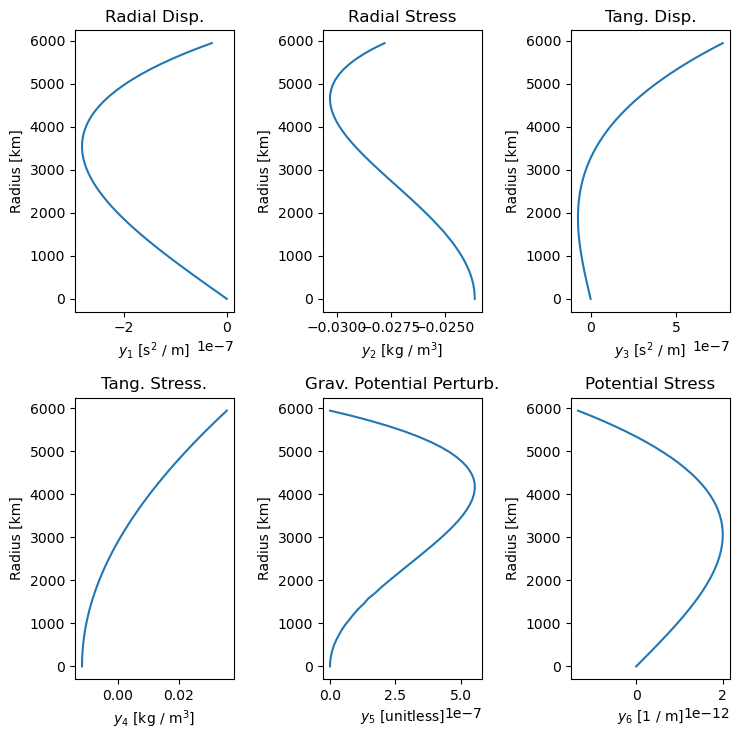

In [21]:
from TidalPy.utilities.graphics.multilayer import yplot
import numpy as np
frequency = 1.0 / (86400.0 * 6.0)
frequency = 0.001
N = 100
radius_array = np.linspace(0.1, 6000.e3, N)
density_array = 3500. * np.ones_like(radius_array)
bulk_modulus_array = 1.0e11 * np.ones_like(radius_array)
viscosity_array = 1.0e18 * np.ones_like(radius_array)
shear_array = 5.0e10 * np.ones_like(radius_array)

from TidalPy.rheology.models import MaxwellRheology
complex_shear_modulus_array = np.empty(N, dtype=np.complex128)
max_rho = MaxwellRheology()
max_rho.vectorize_modulus_viscosity(frequency, shear_array, viscosity_array, complex_shear_modulus_array)


from TidalPy.utilities.spherical_helper import calculate_mass_gravity_arrays
volume_array, mass_array, gravity_array = calculate_mass_gravity_arrays(radius_array, density_array)

planet_bulk_density = 3500.
is_solid_by_layer = (True,)
is_static_by_layer = (False,)
is_incompressible_by_layer = (False,)
upper_radius_by_layer = (radius_array[-1],)

out = radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-9,integration_atol = 1.0e-9,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False,)

_ = yplot(out[:, 0:N:2], radius_array[0:N:2])
#_ = yplot(out, radius_array)




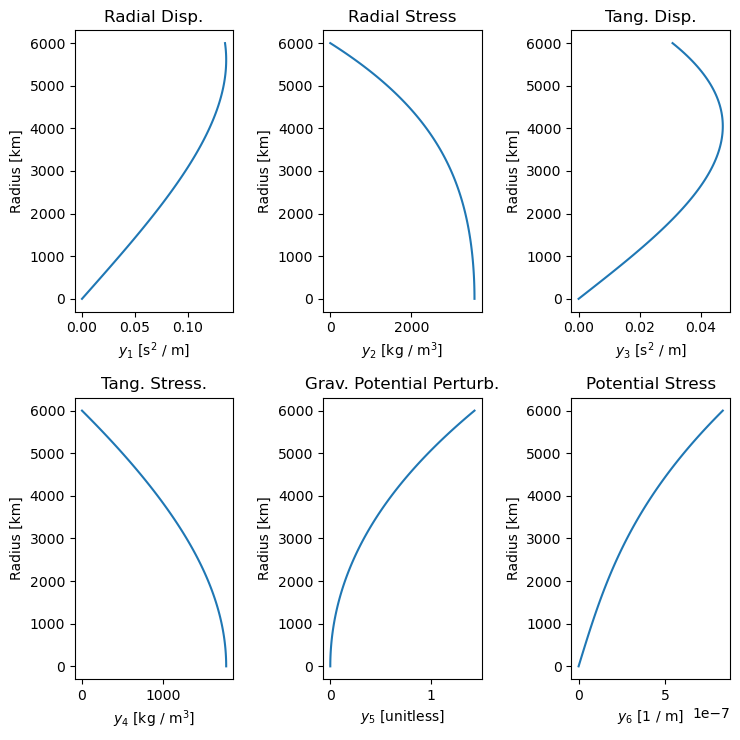

In [16]:
from TidalPy.radial_solver.numerical import radial_solver

indicies = (radius_array>=0.,)

out_old = radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)
_ = yplot(out_old, radius_array)

In [7]:
complex_shear_modulus_array

array([5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j,
       5.e+10+249999.99999375j, 5.e+10+249999.99999375j])

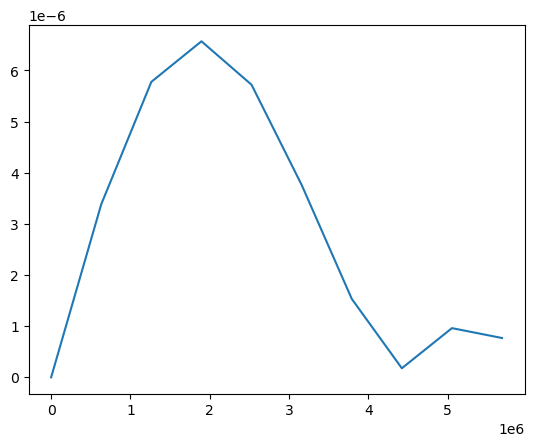

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(radius_array[0:N:2], np.abs(out[0, :][0:N:2]))

In [9]:
np.abs(out[0, :])

array([1.128e-12, 5.639e-01, 3.383e-06, 4.882e-01, 5.777e-06, 2.974e-01,
       6.570e-06, 8.132e-02, 5.721e-06, 6.430e-02, 3.762e-06, 8.725e-02,
       1.534e-06, 3.202e-03, 1.771e-07, 1.171e-01, 9.617e-07, 1.972e-01,
       7.682e-07, 1.867e-01])

In [23]:
# OLD (Not using NonDim):
# 312ms, 311ms
%timeit radial_solver(radius_array,complex_shear_modulus_array,bulk_modulus_array,density_array,gravity_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,indicies,order_l = 2,surface_boundary_condition = None,solve_load_numbers = False,use_kamata = False,integration_method = 'rk45',integration_rtol = 1.0e-9,integration_atol = 1.0e-9,nondimensionalize = False)

# NEW (Not using NonDim):
# 4.93ms, 4.9ms
%timeit radial_solver_x(radius_array,density_array,gravity_array,bulk_modulus_array,complex_shear_modulus_array,frequency,planet_bulk_density,is_solid_by_layer,is_static_by_layer,is_incompressible_by_layer,upper_radius_by_layer,degree_l = 2,surface_boundary_conditions = None,solve_load_numbers = False,use_kamata = False,integration_method = 2,integration_rtol = 1.0e-9,integration_atol = 1.0e-9,scale_rtols_by_layer_type = True,max_num_steps = 500_000,expected_size = 250,max_step = 0,limit_solution_to_radius = True,verbose = False,nondimensionalize = False)


311 ms ± 1.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
4.9 ms ± 33.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
